In [1]:
import os

os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from src.nids.autoencoder import NIDS_AutoEncoder

from data.nslkdd import load_nslkdd, NSLKDD_Preprocessor

In [3]:
def seed_all(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_all(42)

In [4]:
X_train, y_train = load_nslkdd(random_20_percent=False, partition='train')
X_test, y_test = load_nslkdd(random_20_percent=False, partition='test')

In [5]:
# Apply random split
"""
NOTE: In the original paper by Choi et al (2019), the dataset was randomly split in 85/15
We use the same split to try and reproduce their results.
However, it should be noted that random split in IDS datasets is considered a methodological error.
Either temporal split or default split should be used.
"""

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [6]:
X_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
18631,7,tcp,smtp,SF,1585,364,0,0,0,0,...,153,178,0.63,0.03,0.01,0.01,0.01,0.01,0.0,0.0
9456,0,tcp,http,SF,316,3810,0,0,0,0,...,11,255,1.00,0.00,0.09,0.03,0.00,0.01,0.0,0.0
109449,0,tcp,ftp_data,SF,567,0,0,0,0,0,...,189,75,0.27,0.03,0.27,0.03,0.00,0.00,0.0,0.0
13261,0,tcp,http,SF,266,917,0,0,0,0,...,52,255,1.00,0.00,0.02,0.05,0.00,0.00,0.0,0.0
12470,0,tcp,private,S0,0,0,0,0,0,0,...,255,10,0.04,0.09,0.00,0.00,1.00,1.00,0.0,0.0


In [7]:
preprocessor = NSLKDD_Preprocessor()
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [8]:
X_train = X_train.astype(np.float32).to_numpy()
X_test = X_test.astype(np.float32).to_numpy()

y_train = y_train.apply(lambda x: 0 if x == 'normal' else 1).to_numpy()
y_test = y_test.apply(lambda x: 0 if x == 'normal' else 1).to_numpy()

X_train_normal = X_train[y_train == 0]
y_train_normal = y_train[y_train == 0]

In [9]:
model = NIDS_AutoEncoder(n_features=X_train_normal.shape[1], noise_stddev=0.0, calibration_strategy='z_score', z_threshold=2.3)
model.fit(X_train_normal)


In [10]:

def plot_errors(errors, y, calibration_threshold: float=None):
    
    bins = np.linspace(np.min(errors), np.percentile(errors, 99), 100)

    plt.figure(figsize=(10, 5))
    plt.hist(errors[y == 0], bins=bins, alpha=0.5, density=True, label='Normal')
    plt.hist(errors[y == 1], bins=bins, alpha=0.5, density=True, label='Anomaly')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')

    if calibration_threshold is not None:    
        plt.axvline(x=calibration_threshold, color='k', linestyle='--', label='Calibration Threshold')

    plt.legend()
    plt.show()



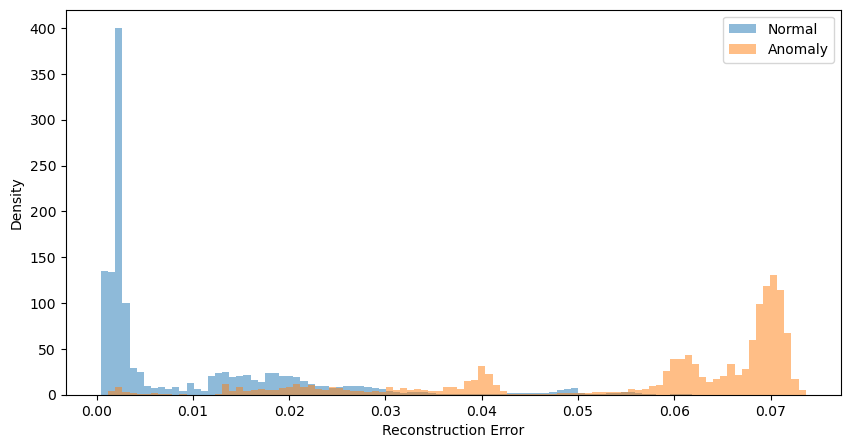

In [11]:
errors_train = model.evaluate_errors(X_train)

plot_errors(errors_train, y_train, calibration_threshold=None)

In [12]:
model.calibrate(X_train_normal)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9041
Precision: 0.9432
Recall: 0.8510
F1 Score: 0.8947


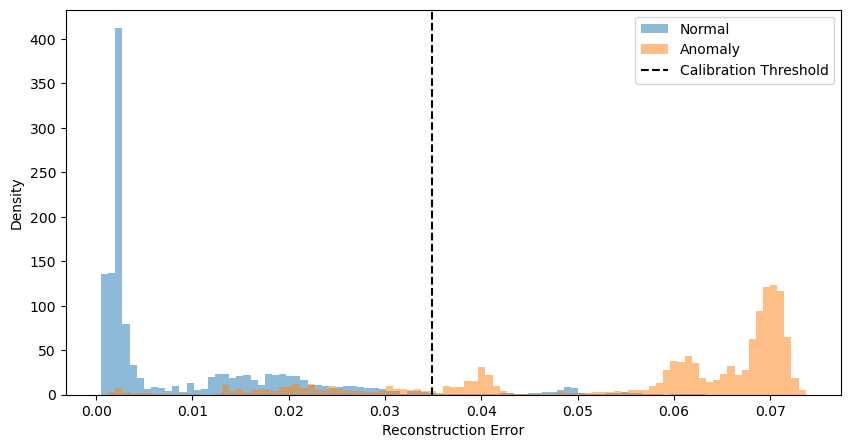

In [13]:
errors_test = model.evaluate_errors(X_test)

plot_errors(errors_test, y_test, calibration_threshold=model.threshold)